In [8]:
# Load libraries and functions
%load_ext autoreload
%autoreload 2
%matplotlib inline
RANDOM_STATE = 42  # Pseudo-random state

from utils import *
sns.set_palette("tab10") # Default seaborn theme

# Extra libraries for this notebook
import cmprsk
from cmprsk import utils
from cmprsk.cmprsk import cuminc
import scikit_posthocs as sph
from statannot import add_stat_annotation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Upload dataset
fn_vae_data = glob.glob('./data/Updated*.pkl')
latest_fn_vae_data = max(fn_vae_data, key=os.path.getctime)

print("Loading... ",latest_fn_vae_data)
with open(latest_fn_vae_data, "rb") as f:
    vae_data_main = pickle.load(f)
print("Done")

Loading...  ./data/Updated_VAE_Data_Main_0821_1424.pkl
Done


# Define functions

In [10]:
######### Posthoc analysis for multiple groups by chi-square test

def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text

def chisq_and_posthoc_corrected(df):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi(df, correction=True)
    print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")
    
    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    print("Significance results:")
    for comb in all_combinations:
        new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
        chi2, p, dof, ex = chi(new_df, correction=True)
        p_vals.append(p)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)})")
        
        

# Divide patients into groups and compare groups

In [11]:
# Select group data
data_vap = vae_data_main[(vae_data_main.group=='VA-HARTI')]
data_nva = vae_data_main[(vae_data_main.group=='NVA-HARTI')]
data_no_hai = vae_data_main[(vae_data_main.group=='No HAI')]
data_other_hai = vae_data_main[(vae_data_main.group=='Other HAI')]
data_both = vae_data_main[(vae_data_main.group=='VA+NVA HARTI')]

dsets = {'vap': data_vap, 
         'nva': data_nva, 
         'no_hai': data_no_hai,
         'other_hai' : data_other_hai,
         'both' : data_both
        }

# Select factors to compare
# Numerical factors
FACTORS = ['age', 'charlson',  # condition on admission
           
           'consciousness', 'rass',  # severity of patients condition before infection
           'pbss', 'aphasia', 'day_in_icu',
           
           'mech_vent_d',   'antibiotics_total_binary_d',  # ICU care
             'central_line_d', 'feeding_tube_d', 'arterial_line_d', 'evd_d', 'icpm_d',
             'urinary_catheter_d', 'hypothermia_d', 'hemodialysis_d', 'total_parenteral_feeding_d',
             'sedation_d', 'anxiolytics_d', 'vasopressors_d', 'days_mech_vent_before_tracheostomy',
             'days_before_tracheostomy',
            
           'intestinal_dysfunction_d', 'infection_bloodstream_d', 'infection_other_d',  # infectious complications
             'infection_urinary_d', 'infection_cns_d'
           
           ]

# Proportional factors
FACTORS_2 = ['gender_M', 'disease_type_trauma', 'disease_type_tumor', # condition on admission
             'disease_type_vascular', 'disease_type_other',
             
             'mech_vent',   'antibiotics_total_binary',  # ICU care
             'central_line', 'feeding_tube', 'arterial_line', 'evd', 'icpm',
             'urinary_catheter', 'hypothermia', 'hemodialysis', 'total_parenteral_feeding',
             'sedation', 'anxiolytics', 'vasopressors',
           
             'intestinal_dysfunction', 'infection_bloodstream', 'infection_other',  # infectious complications
             'infection_urinary', 'infection_cns'
            ]


In [12]:
# Define function for factors data type
class AggFunc:
    def __call__(self, x):
        nobs = len(x)
        count = x.sum()
        left, right = ci(count, nobs)
        return round(left, 3), round(right, 3)
    
    def __repr__(self):
        return "CI"

# Calculate values for group comparison
cols = list(set(FACTORS + FACTORS_2))

group_dict = {}
for k, d in dsets.items():
    group_dict[k] = {}
    
    for v in ['mean', 'std', AggFunc()]:
        vals = d[['ID_subid'] + cols].groupby('ID_subid').max().agg(v)
    
        v = str(v)
        
        if v in ['mean', 'std']:
            for col in cols:
                if not (col in FACTORS):
                    continue

                group_dict[k][col + '_' + v] = vals[col]
        
        
        if v in ['mean', 'CI']:
            for col in cols:
                if not (col in FACTORS_2):
                    continue

                group_dict[k][col + '_' + v] = vals[col]

        
vals = d[['ID_subid', 'day_in_icu_max']].groupby('ID_subid').max().sum()

# Create a table
table_2 = pd.DataFrame(group_dict)
res = {}
for factor in FACTORS:
    
    res[factor + '_mean'] = kruskal(data_vap[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                                    data_nva[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                                    data_no_hai[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                                    data_other_hai[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                                    data_both[['ID_subid', factor]].groupby('ID_subid').max()[factor].values).pvalue

if not table_2.columns.str.contains('pvalue').max():
    table_2 = table_2.join(pd.DataFrame({'pvalue': res}))
    
res = {}
for factor in FACTORS_2:
    vals = [data_vap[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values,
            data_nva[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values,
            data_no_hai[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values,
            data_other_hai[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values,
            data_both[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values
           ]
    pvalue = chi(vals)[1]
    table_2.loc[factor + '_mean', 'pvalue'] = pvalue
    
table_2['adjusted_pvalue'] = pd.Series(multipletests(table_2.pvalue.dropna().values)[1],
                                       index=table_2.pvalue.dropna().index)
table_2['adjusted_pvalue'] = table_2['adjusted_pvalue'].apply(lambda x: round(x, 5))

table_2.to_csv('./table_2.csv', sep='\t', encoding='utf-8')
table_2

,vap,nva,no_hai,other_hai,both,pvalue,adjusted_pvalue
arterial_line_d_mean,6.46827,3.17259,0.779799,2.11449,8.10526,5.479051e-104,0.00000
antibiotics_total_binary_d_mean,22.9147,14.6345,2.21267,9.93333,55.2105,2.263495e-304,0.00000
vasopressors_d_mean,7.39387,3.2335,0.914053,2.38696,11.8421,6.598735e-86,0.00000
days_before_tracheostomy_mean,3.91842,3.96748,3.54717,4.65714,5.625,NaN,NaN
aphasia_mean,0.115974,0.106599,0.06399,0.0869565,0.210526,4.980737e-04,0.00497
...,...,...,...,...,...,...,...
sedation_CI,"(0.602, 0.689)","(0.484, 0.623)","(0.214, 0.256)","(0.317, 0.388)","(0.415, 0.848)",NaN,NaN
disease_type_trauma_CI,"(0.216, 0.296)","(0.174, 0.293)","(0.047, 0.071)","(0.087, 0.134)","(0.065, 0.461)",NaN,NaN
disease_type_vascular_CI,"(0.208, 0.287)","(0.193, 0.315)","(0.218, 0.26)","(0.199, 0.262)","(0.0, 0.243)",NaN,NaN
arterial_line_CI,"(0.584, 0.672)","(0.323, 0.459)","(0.163, 0.201)","(0.28, 0.349)","(0.475, 0.893)",NaN,NaN


# Compare ICU LOS

In [13]:
# Data from main dataset
df_admissions = vae_data_main[['los', 'day_in_icu_max', 'ID_subid', 'ID', 'outcome_death', 'date', 'group']]
df_admissions = df_admissions.groupby('ID_subid').agg({'los': max, 'day_in_icu_max':max, 'group':max,
                                 'date': min, 'ID':max, 'outcome_death':max,})
df_admissions.date = df_admissions.date.dt.year

In [14]:
# Compare groups by ANOVA (normal distribution assumption)
lm = smf.ols('day_in_icu_max ~ group', data=df_admissions).fit()
anova = sm.stats.anova_lm(lm)
print(anova)

# Compare groups by Kruskal test (non-parametric)
data = [df_admissions.loc[ids, 'day_in_icu_max'].values for ids in df_admissions.groupby('group').groups.values()]
H, p = stats.kruskal(*data)
print('\nKruskal test p-value: ', p)

# Compare groups pairwise (non-parametric Conover test)
sph.posthoc_conover(df_admissions, val_col='day_in_icu_max', group_col='group', p_adjust ='holm')

              df        sum_sq        mean_sq           F         PR(>F)
group        4.0  5.682285e+05  142057.125026  157.161375  4.571132e-122
Residual  2952.0  2.668293e+06     903.893373         NaN            NaN

Kruskal test p-value:  2.9678200107376887e-276


,NVA-HARTI,No HAI,Other HAI,VA+NVA HARTI,VA-HARTI
NVA-HARTI,-1.000000e+00,2.169835e-95,7.912126e-07,6.271527e-07,7.360889e-11
No HAI,2.169835e-95,-1.000000e+00,6.276390e-141,3.858113e-34,5.048900e-297
Other HAI,7.912126e-07,6.276390e-141,-1.000000e+00,5.827317e-12,1.137030e-56
VA+NVA HARTI,6.271527e-07,3.858113e-34,5.827317e-12,-1.000000e+00,3.960519e-03
VA-HARTI,7.360889e-11,5.048900e-297,1.137030e-56,3.960519e-03,-1.000000e+00


In [15]:
# Display desriptive data by groups for ICU LOS
df_admissions[['day_in_icu_max', 'group']].groupby('group').describe().T

group                  NVA-HARTI       No HAI   Other HAI  VA+NVA HARTI  \
day_in_icu_max count  197.000000  1594.000000  690.000000     19.000000   
               mean    25.477157     6.867001   19.879710    115.684211   
               std     33.452918     5.165546   36.886501    157.848751   
               min      3.000000     2.000000    2.000000     33.000000   
               25%     10.000000     4.000000    7.000000     50.500000   
               50%     15.000000     6.000000   13.000000     77.000000   
               75%     30.000000     8.000000   23.000000    116.000000   
               max    309.000000    48.000000  839.000000    748.000000   

group                   VA-HARTI  
day_in_icu_max count  457.000000  
               mean    37.921225  
               std     47.306605  
               min      4.000000  
               25%     17.000000  
               50%     26.000000  
               75%     44.000000  
               max    707.000000

# Compare hospital LOS

In [16]:
# Group attribution is selected by hierarchy 
df_individuals = df_admissions.copy()

groups_dict = {
    'No HAI' : 1,
    'Other HAI' : 2,
    'NVA-HARTI' : 3,
    'VA-HARTI' : 4,
    'VA+NVA HARTI' : 5
}

df_individuals.group = df_individuals.group.map(groups_dict)
df_individuals = df_individuals.groupby('ID').agg({'los': max, 'day_in_icu_max':max, 'group':max,
                                 'date': min, 'outcome_death':max,})

# Calculate individuals with infections
df_individuals.group.value_counts()

1    1435
2     609
4     454
3     191
5      19
Name: group, dtype: int64

In [17]:
# Compare groups by ANOVA (normal distribution assumption)
lm = smf.ols('los ~ group', data=df_individuals).fit()
anova = sm.stats.anova_lm(lm)
print(anova)

# Compare groups by Kruskal test (non-parametric)
data = [df_individuals.loc[ids, 'los'].values for ids in df_individuals.groupby('group').groups.values()]
H, p = stats.kruskal(*data)
print('\nKruskal test p-value: ', p)

# Compare groups pairwise (non-parametric Conover test)
sph.posthoc_conover(df_individuals, val_col='los', group_col='group', p_adjust ='holm')

              df        sum_sq        mean_sq           F        PR(>F)
group        1.0  8.910790e+05  891078.957230  268.542476  1.283348e-57
Residual  2706.0  8.979062e+06    3318.204888         NaN           NaN

Kruskal test p-value:  1.7576416341589197e-159


,1,2,3,4,5
1,-1.000000e+00,1.745335e-80,7.733647e-40,5.840598e-144,7.751146e-22
2,1.745335e-80,-1.000000e+00,2.771211e-01,1.314823e-15,6.729724e-08
3,7.733647e-40,2.771211e-01,-1.000000e+00,3.112701e-06,1.157997e-06
4,5.840598e-144,1.314823e-15,3.112701e-06,-1.000000e+00,1.017264e-03
5,7.751146e-22,6.729724e-08,1.157997e-06,1.017264e-03,-1.000000e+00


In [18]:
# Display desriptive data by groups for ICU LOS and LOS
df_individuals[['los', 'group']].groupby('group').describe().T

group                1            2           3           4           5
los count  1435.000000   609.000000  191.000000  454.000000   19.000000
    mean     21.995122    46.768473   48.319372   65.348018  158.052632
    std      17.142624    94.446173   50.130226   67.487731  155.780285
    min       1.000000     4.000000    4.000000    3.000000   40.000000
    25%      13.000000    21.000000   21.000000   29.250000   84.500000
    50%      18.000000    32.000000   34.000000   49.000000  124.000000
    75%      26.000000    53.000000   53.500000   82.000000  178.000000
    max     228.000000  2190.000000  343.000000  708.000000  747.000000

# Compare mortality

In [19]:
# Describe mortality by groups
mortality = {}
for group in df_individuals.group.unique():
    mortality[group] = {}
    a = df_individuals[(df_individuals.group==group)]
    mortality[group]['n'] = a.outcome_death.sum()
    mortality[group]['mortality'] = a.outcome_death.mean()
    cil, cir = ci(a.outcome_death.sum(), len(a))
    mortality[group]['cil'] = cil
    mortality[group]['cir'] = cir
mortality = pd.DataFrame.from_dict(mortality)
mortality

,2,1,4,3,5
n,86.000000,142.000000,86.000000,30.000000,7.000000
mortality,0.141215,0.098955,0.189427,0.157068,0.368421
cil,0.113557,0.083505,0.153383,0.105465,0.151522
cir,0.168873,0.114404,0.225472,0.208671,0.585320


In [20]:
# Print combined groups mortality data
print('All patients mortality rate: ', df_individuals.outcome_death.mean())
cil, cir = ci(df_individuals.outcome_death.sum(), len(df_individuals))
print("All patients mortality 95% CI: ", cil, cir)

print('\nAll HARTI mortality rate: ', df_individuals[(df_individuals.group.isin([3,4,5]))].outcome_death.mean())
cil, cir = ci(df_individuals[(df_individuals.group.isin([3,4,5]))].outcome_death.sum(), len(df_individuals[(df_individuals.group.isin([3,4,5]))]))
print("All HARTI mortality 95% CI: ", cil, cir)

print('\nNo HARTI mortality rate: ', df_individuals[(df_individuals.group.isin([1,2]))].outcome_death.mean())
cil, cir = ci(df_individuals[(df_individuals.group.isin([1,2]))].outcome_death.sum(), len(df_individuals[(df_individuals.group.isin([1,2]))]))
print("No HARTI mortality 95% CI: ", cil, cir)

vals = [df_individuals[(df_individuals.group.isin([3,4,5]))].outcome_death.agg(['count', 'sum']).values,
        df_individuals[(df_individuals.group.isin([1,2]))].outcome_death.agg(['count', 'sum']).values]
print('\np-value All HARTI vs No HARTI: ', "%.6f" % chi(vals)[1])

All patients mortality rate:  0.129615952732644
All patients mortality 95% CI:  0.11696543060829537 0.14226647485699265

All HARTI mortality rate:  0.1852409638554217
All HARTI mortality 95% CI:  0.15569166637279663 0.21479026133804674

No HARTI mortality rate:  0.11154598825831702
No HARTI mortality 95% CI:  0.09789851979465417 0.12519345672197987

p-value All HARTI vs No HARTI:  0.000029


In [21]:
# Compare mortality in groups by chi-sq test. Pairwise comparison
vals = {}
for group in df_individuals.group.unique():
    vals[group] = df_individuals[(df_individuals.group==group)].outcome_death.agg(['count', 'sum']).values

f = pd.DataFrame.from_dict(vals)
chisq_and_posthoc_corrected(f.T)

Chi2 result of the contingency table: 27.628339510935948, p-value: 1.4834045953306848e-05
Significance results:
(2, 1): p_value: 0.016969; corrected: 0.056562 (*)
(2, 4): p_value: 0.088107; corrected: 0.146844 (ns)
(2, 3): p_value: 0.725321; corrected: 0.725321 (ns)
(2, 5): p_value: 0.060790; corrected: 0.121580 (ns)
(1, 4): p_value: 0.000011; corrected: 0.000109 (****)
(1, 3): p_value: 0.041230; corrected: 0.103074 (*)
(1, 5): p_value: 0.005427; corrected: 0.027133 (**)
(4, 3): p_value: 0.478886; corrected: 0.532096 (ns)
(4, 5): p_value: 0.227367; corrected: 0.284209 (ns)
(3, 5): p_value: 0.130134; corrected: 0.185906 (ns)


# Plot hospital LOS, ICU LOS and mortality by groups

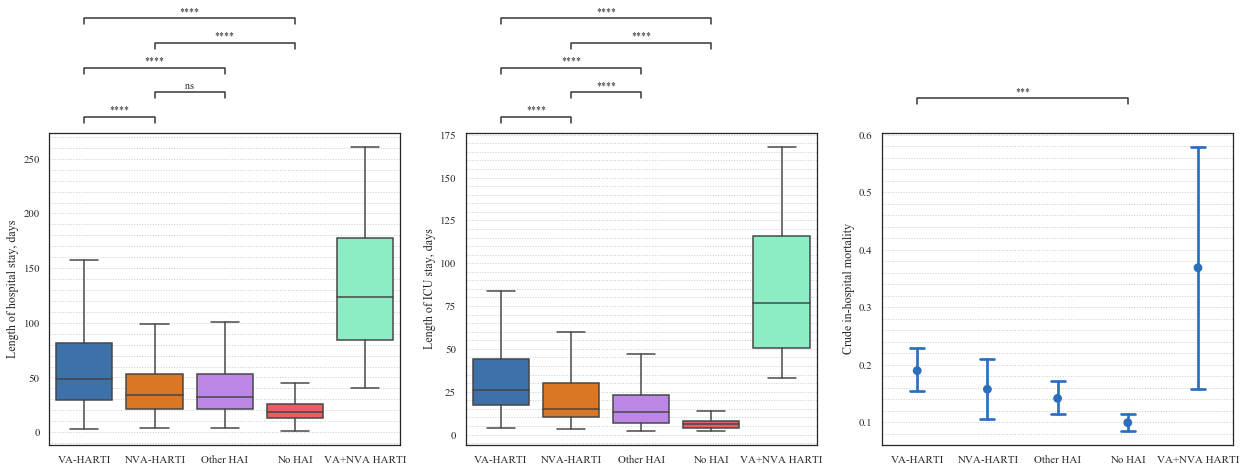

In [22]:
# Define comparisons
colors_sns = ['medium blue', 'orange', 'light purple', 'light red', 'light aquamarine']
sns.set_palette(sns.xkcd_palette(colors_sns))

fig, [ax, ax1, ax2] = plt.subplots(1,3, figsize=(17.5, 7))


# ICU LOS
boxpairs=[('VA-HARTI', 'NVA-HARTI'), ('VA-HARTI', 'Other HAI'), ('VA-HARTI', 'No HAI'),
          ('NVA-HARTI', 'No HAI'), ('NVA-HARTI', 'Other HAI')]
order = ['VA-HARTI', 'NVA-HARTI', 'Other HAI', 'No HAI', 'VA+NVA HARTI']
sns.boxplot(x='group', y='day_in_icu_max', data=df_admissions, ax=ax1, showfliers=False, order=order)
# Add p-value annotation
pvals_iculos_all = sph.posthoc_conover(df_admissions, val_col='day_in_icu_max', group_col='group', p_adjust ='holm')
pvalues_iculos=[pvals_iculos_all['VA-HARTI']['NVA-HARTI'], pvals_iculos_all['VA-HARTI']['Other HAI'],
                pvals_iculos_all['VA-HARTI']['No HAI'], pvals_iculos_all['NVA-HARTI']['No HAI'],
                pvals_iculos_all['VA-HARTI']['Other HAI']]
add_stat_annotation(ax=ax1, data=df_admissions, x='group', y='day_in_icu_max', order=order, box_pairs=boxpairs,
                    perform_stat_test=False, pvalues=pvalues_iculos,
                    test=None, text_format='star',
                    loc='outside', verbose=0, text_offset=1)
ax1.minorticks_on()
ax1.grid(linestyle='dotted', which='both', axis='y')
ax1.set_xlabel('')
ax1.set_ylabel('Length of ICU stay, days')


# LOS
boxpairs=[(4, 3), (4, 2), (4, 1), (3, 1), (3, 2)]
order=[4, 3, 2, 1, 5]
sns.boxplot(x='group', y='los', data=df_individuals, ax=ax, showfliers=False, order=order)
# Add p-value annotation
pvals_los_all = sph.posthoc_conover(df_individuals, val_col='los', group_col='group', p_adjust ='holm')
pvalues_los = [pvals_los_all[4][3], pvals_los_all[4][2], pvals_los_all[4][1],
               pvals_los_all[3][1], pvals_los_all[3][2]
              ]
add_stat_annotation(ax=ax, data=df_individuals, x='group', y='los', order=order, box_pairs=boxpairs,
                    perform_stat_test=False, pvalues=pvalues_los,
                    test=None, text_format='star',
                    loc='outside', verbose=0, text_offset=1)
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='y')
ax.set_xlabel('')
ax.set_xticklabels(['VA-HARTI', 'NVA-HARTI', 'Other HAI', 'No HAI', 'VA+NVA HARTI'])
ax.set_ylabel('Length of hospital stay, days')

# Mortality rate
sns.pointplot(x='group', y="outcome_death", data=df_individuals, join=False, ax=ax2,
              order=order, capsize=.2)
# Add p-value annotation
# pvalues_mort=[0.532096, 0.146844, 0.000109, 0.103074, 0.725321]
add_stat_annotation(ax=ax2, data=df_individuals, x='group', y='outcome_death', order=order,
                    box_pairs=[(4, 1)],
                    perform_stat_test=False, pvalues=[0.000109],
                    test=None, text_format='star',
                    line_offset_to_box=1.2,
                    loc='outside',
                    verbose=0,
                   )
ax2.minorticks_on()
ax2.grid(linestyle='dotted', which='both', axis='y')
ax2.set_xlabel('')
ax2.set_xticklabels(['VA-HARTI', 'NVA-HARTI', 'Other HAI', 'No HAI', 'VA+NVA HARTI'])
ax2.set_ylabel('Crude in-hospital mortality')
plt.tight_layout()
plt.savefig('./pictures/outcomes_all.pdf', dpi=600)

# Dynamics of mortality by groups and years

In [23]:
 # Calculate numbers for mortality by years
medians = {}
for group in df_individuals.group.unique():
    m = []
    a = df_individuals[(df_individuals.group==group)]
    for i in range(2011,2019):
        b = a[(a.date == i)]
        val = b.outcome_death.sum() / len(b)
        m.append(val)
    medians[group] = m
mortality_years = pd.DataFrame.from_dict(medians).T

# test significance of outcome dynamics by years
pvals = []
for col in mortality_years.index:
    a = linregress(mortality_years.T[col], np.arange(len(mortality_years.T[col]))).pvalue
    pvals.append(a)
mortality_years = mortality_years.assign(pvalues = pvals)
mortality_years

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


,0,1,2,3,4,5,6,7,pvalues
2,0.171875,0.250000,0.170732,0.126582,0.101266,0.166667,0.070588,0.095238,0.033518
1,0.161972,0.128000,0.111765,0.109756,0.141243,0.052381,0.084444,0.049550,0.010560
4,0.196721,0.270588,0.228070,0.127273,0.187500,0.217391,0.113208,0.122449,0.078412
3,0.055556,0.269231,0.272727,0.172414,0.083333,0.222222,0.125000,0.058824,0.464491
5,0.250000,0.000000,0.666667,0.000000,0.500000,0.000000,0.600000,NaN,NaN


In [24]:
mortality_years

,0,1,2,3,4,5,6,7,pvalues
2,0.171875,0.250000,0.170732,0.126582,0.101266,0.166667,0.070588,0.095238,0.033518
1,0.161972,0.128000,0.111765,0.109756,0.141243,0.052381,0.084444,0.049550,0.010560
4,0.196721,0.270588,0.228070,0.127273,0.187500,0.217391,0.113208,0.122449,0.078412
3,0.055556,0.269231,0.272727,0.172414,0.083333,0.222222,0.125000,0.058824,0.464491
5,0.250000,0.000000,0.666667,0.000000,0.500000,0.000000,0.600000,NaN,NaN


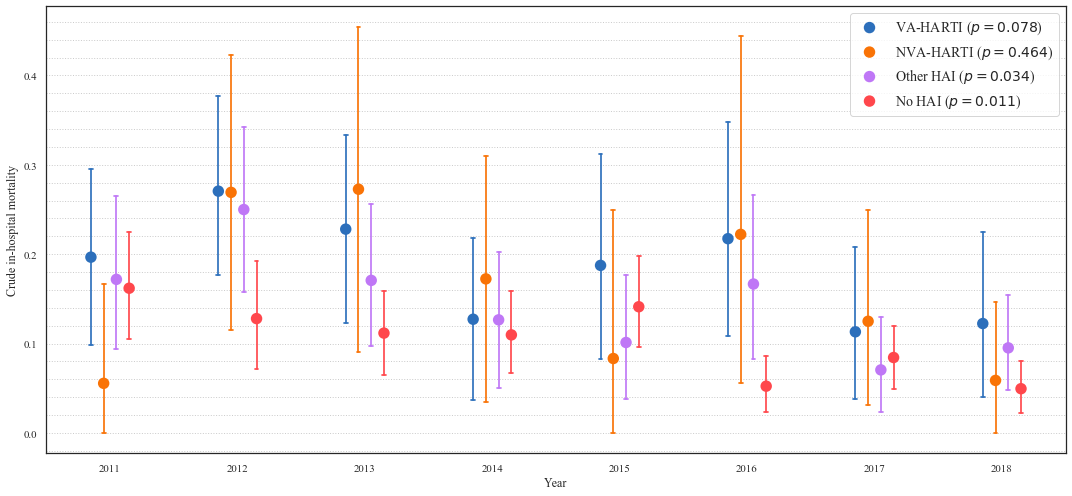

In [25]:
# Define data; add p-value to legend items
def get_p_suffix(x, g_dict=None):
    pval = mortality_years.pvalues.dropna().to_dict().get(x, None)
    if pval is not None:
        return f'{x} ($p={pval:.03f}$)'
    return x


if not 'No HAI' in mortality_years.index:
    mortality_years.index = mortality_years.index.map({v: k for k, v in groups_dict.items()})

data = df_individuals.copy()
data.group = data.group.map({groups_dict[k] : k for k in groups_dict})
data.group = data.group.apply(get_p_suffix)

# Plot proroption dead with 95% CI
fig, ax = plt.subplots(1, figsize=(15,7))
sns.pointplot(x='date', y="outcome_death", data=data, ax=ax,
              hue='group',
              hue_order=data.group.unique()[:-1][[2,3,0,1]],
              dodge=0.3,
              capsize=.03,
              scale=1.3,
              errwidth = 1.7,
              join=False
             )

ax.legend(fontsize=14)
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='y')
ax.set_xlabel('Year')
ax.set_ylabel('Crude in-hospital mortality')

plt.tight_layout()
plt.savefig('./pictures/outcome_mortality.pdf', dpi=600)

[0.16608996539792387, 0.20766773162939298, 0.16167664670658682, 0.12121212121212122, 0.13836477987421383, 0.1044776119402985, 0.095, 0.06940874035989718]


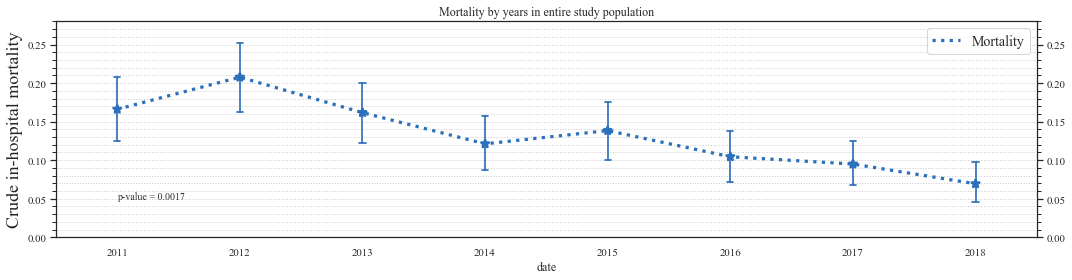

In [49]:
# Plot proroption dead with 95% CI
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
fig, ax = plt.subplots(1, figsize=(15,4))
sns.pointplot(x='date', y="outcome_death", data=df_individuals, ax=ax,
              capsize=.05,
              scale=1.2,
              errwidth = 1.7,
              markers='*', linestyles='dotted',
              join=True
             )

m = []
for i in range(2011,2019):
    b = df_individuals[(df_individuals.date == i)]
    val = b.outcome_death.mean()
    m.append(val)
pval = linregress(m, np.arange(len(m))).pvalue
ax.text(0,0.05, 'p-value = '+ "%.4f" % pval)
ax.legend(['Mortality'], fontsize=14)
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='y')
ax.tick_params(axis='y', which='both', right=True, left=True)
ax.set_title('Mortality by years in entire study population')
ax.set_ylabel('Crude in-hospital mortality', fontsize=18)
ax.set_ylim(0,0.28)
print(m)

plt.tight_layout()
plt.savefig('./pictures/outcome_mortality_summary.pdf', dpi=600)
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False

In [37]:
inc_vap

,year,vap
ID_subid,,
1/160,2016.5,0.0
1002/160,2016.5,0.0
1004/160,2016.5,0.0
1006/170,2017.5,1.0
1007/150,2015.5,0.0
...,...,...
994/140,2014.5,0.0
994/160,2016.5,0.0
994/161,2016.5,0.0


In [33]:
vae_data_main[['ID_subid', 'year', 'infection_respiratory']].groupby('ID_subid').max().year

ID_subid
1/160       2016
1002/160    2016
1004/160    2016
1006/170    2017
1007/150    2015
            ... 
994/140     2014
994/160     2016
994/161     2016
998/130     2013
998/150     2015
Name: year, Length: 2957, dtype: int64

# Dynamics of hospital LOS by groups and years

In [41]:
# Calculate numbers for LOS
medians = {}
for group in df_individuals.group.unique():
    m = []
    a = df_individuals[(df_individuals.group==group)]
    for i in range(2011,2019):
        b = a[(a.date == i)].los.median()
        m.append(b)
    medians[group] = m
los = pd.DataFrame.from_dict(medians).T

# test significance of outcome dynamics by years
pvals = []
for col in los.index:
    a = linregress(los.T[col], np.arange(len(los.T[col]))).pvalue
    pvals.append(a)
los = los.assign(pvalues = pvals)
los

,0,1,2,3,4,5,6,7,pvalues
2,38.5,34.0,34.0,32.0,33.0,38.5,27.0,27.0,0.069406
1,22.0,21.0,19.0,19.0,17.0,19.0,15.0,16.0,0.002138
4,52.0,52.0,58.0,46.0,65.5,39.5,36.0,33.0,0.083230
3,35.0,39.0,43.5,36.0,34.5,31.5,26.5,32.0,0.057704
5,183.0,193.0,90.0,215.0,151.0,89.0,84.0,NaN,NaN


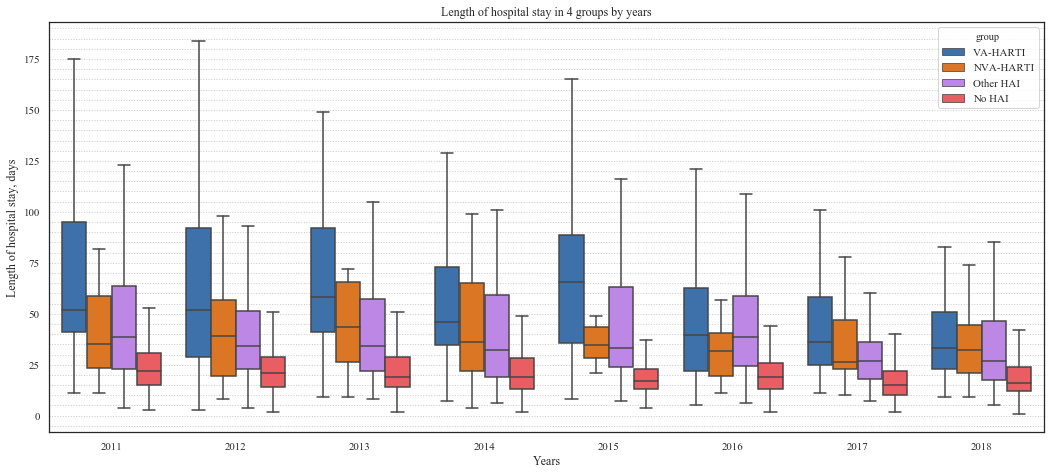

In [42]:
# Get p-values
def get_p_suffix(x):
    pval = los.pvalues.dropna().to_dict().get(x, None)
    if pval is not None:
        return f'{x} ($p={pval:.03f}$)'
    return x

data = df_individuals.copy()
data.group = data.group.map({groups_dict[k] : k for k in groups_dict})
data.group = data.group.apply(get_p_suffix)

# Plot boxplots by years and groups
colors_sns = ['medium blue', 'orange', 'light purple', 'light red']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.boxplot(x='date', y='los', hue='group', data=data, ax=ax,
            showfliers=False,
            hue_order=data.group.unique()[:-1][[2,3,0,1]],
           )

ax.set_title('Length of hospital stay in 4 groups by years')
ax.set_ylabel('Length of hospital stay, days')
ax.set_xlabel('Years')
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='y')

plt.tight_layout()
plt.savefig('pictures/los_years.pdf', bbox_inches="tight", dpi=600)

# Dynamics of ICU LOS by groups and years

In [43]:
# Calculate numbers for ICU LOS
medians = {}
for group in df_admissions.group.unique():
    m = []
    a = df_admissions[(df_admissions.group==group)]
    for i in range(2011,2019):
        b = a[(a.date == i)].day_in_icu_max.median()
        m.append(b)
    medians[group] = m
losicu = pd.DataFrame.from_dict(medians).T

# test significance of outcome dynamics by years
pvals = []
for col in losicu.index:
    a = linregress(losicu.T[col], np.arange(len(losicu.T[col]))).pvalue
    pvals.append(a)
losicu = losicu.assign(pvalues = pvals)
losicu

,0,1,2,3,4,5,6,7,pvalues
Other HAI,16.0,15.0,12.0,12.0,15.0,15.0,11.5,9.0,0.076758
No HAI,7.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0,0.005601
VA-HARTI,30.0,24.0,30.0,28.0,32.5,26.5,24.5,21.0,0.195370
NVA-HARTI,23.0,12.0,16.5,19.0,22.5,11.0,13.0,13.0,0.231755
VA+NVA HARTI,59.5,168.0,86.0,117.0,113.0,69.0,36.0,NaN,NaN


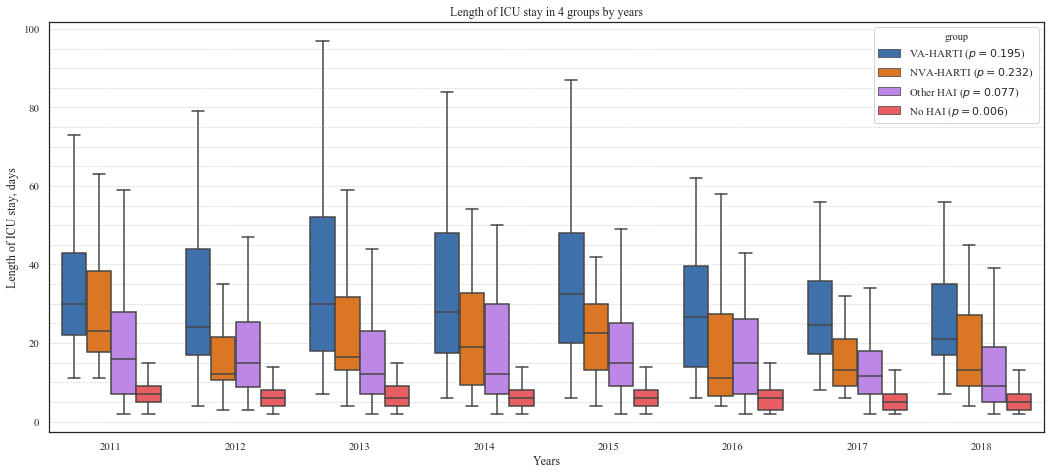

In [44]:
# Get p-values
def get_p_suffix(x):
    pval = losicu.pvalues.dropna().to_dict().get(x, None)
    if pval is not None:
        return f'{x} ($p={pval:.03f}$)'
    return x

data = df_admissions.copy()
data.group = data.group.apply(get_p_suffix)

# Plot boxplots by years and groups
colors_sns = ['medium blue', 'orange', 'light purple', 'light red']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.boxplot(x='date', y='day_in_icu_max', hue='group', data=data, ax=ax,
            showfliers=False,
            hue_order=data.group.unique()[:-1][[2,3,0,1]],
           )
ax.set_title('Length of ICU stay in 4 groups by years')
ax.set_ylabel('Length of ICU stay, days')
ax.set_xlabel('Years')
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='y')

plt.tight_layout()
plt.savefig('pictures/los_icu_years.pdf', bbox_inches="tight", dpi=600)

________

# Survival analysis

In [45]:
# Select IDs for all groups
f1 = df_individuals[(df_individuals.group ==1)].index.unique().tolist()
f2 = df_individuals[(df_individuals.group ==2)].index.unique().tolist()
f3 = df_individuals[(df_individuals.group ==3)].index.unique().tolist()
f4 = df_individuals[(df_individuals.group ==4)].index.unique().tolist()
f5 = df_individuals[(df_individuals.group ==5)].index.unique().tolist()

No HAI median:  los    10.0
dtype: float64
VA-HAI median:  los    34.0
dtype: float64
NVA-HAI median:  los    35.0
dtype: float64


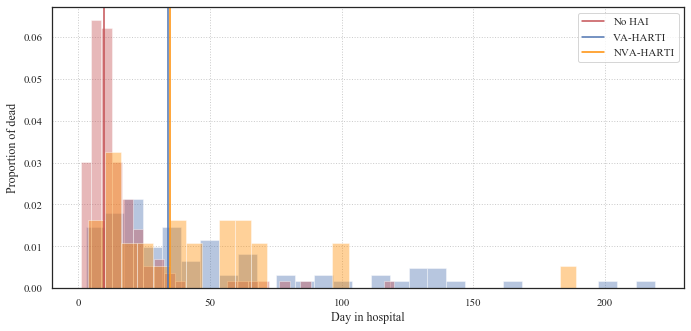

In [46]:
# Plot historgam of death time
# Define data
T = vae_data_main[['ID', 'los']].groupby('ID').max()
E = vae_data_main[['ID', 'outcome_death']].groupby('ID').max()
a = b = c = T[E.outcome_death == 1]
a = a[a.index.isin(f1)]  
b = b[b.index.isin(f4)] #vap
c = c[c.index.isin(f3)] #nva
a = a[a.los <= 365]
b = b[b.los <= 365]
c = c[c.los <= 365]

# Plot
plt.figure(figsize=(10,5))
ax = sns.distplot(b, kde=False, color='b', bins=30, norm_hist=True)
sns.distplot(a, kde=False, ax=ax, color='r', bins=30, norm_hist=True)
sns.distplot(c, kde=False, ax=ax, color='darkorange', bins=30, norm_hist=True)
plt.axvline(a.median()[0], color='r')
plt.axvline(b.median()[0], color='b')
plt.axvline(c.median()[0], color='darkorange')
ax.legend(['No HAI', 'VA-HARTI', 'NVA-HARTI'])
ax.set_ylabel('Proportion of dead')
ax.set_xlabel('Day in hospital')
ax.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('./pictures/deathtime_hist.pdf', dpi=600)
print('No HAI median: ', a.median())
print('VA-HAI median: ', b.median())
print('NVA-HAI median: ', c.median())

In [47]:
b.describe()

,los
count,85.000000
mean,50.788235
std,46.722100
min,3.000000
25%,18.000000
50%,34.000000
75%,66.000000
max,219.000000


## Beat immortal-time bias with Varying-time Cox model

In [50]:
###### VA-HARTI

# Create base df with death
base_df = vae_data_main[['ID', 'day_in_icu_max', 'outcome_death',
                         'age', 'gender_M', 'disease_type_trauma', 'disease_type_tumor',
                          'disease_type_vascular', 'charlson', 'group'
                        ]].groupby('ID').max()
base_df = base_df.loc[base_df.group.isin(['No HAI', 'VA-HARTI', 'VA+NVA HARTI']), :]
base_df = base_df.drop(['group'], axis=1)
base_df = base_df.reset_index()
base_df.columns = ['id', 'duration', 'event', 'age', 'gender_M', 'disease_type_trauma', 'disease_type_tumor',
                          'disease_type_vascular', 'charlson']
base_df = to_long_format(base_df, duration_col="duration")

# Create HARTI df
event_df = vae_data_main[['ID', 'day_in_icu_bid', 'group']].groupby('ID').max()
event_df = event_df.loc[event_df.group.isin(['VA-HARTI', 'VA+NVA HARTI']), :]
event_df = event_df.drop(['group'], axis=1)
event_df = event_df.reset_index()
event_df.columns = ['id', 'vap']

# Add covariates
cv = covariates_from_event_matrix(event_df, id_col="id")

# Combine base and harti dfs
base_df = add_covariate_to_timeline(base_df, cv, duration_col="duration", id_col="id", event_col="event")
base_df = base_df.fillna(0)
base_df

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:983: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


,age,charlson,disease_type_trauma,disease_type_tumor,disease_type_vascular,event,gender_M,id,start,stop,vap
0,35.000000,2.0,0.0,1.0,0.0,0,1.0,1002/16,0.0,2.0,0.0
1,58.000000,4.0,0.0,1.0,0.0,0,1.0,1004/16,0.0,14.0,0.0
2,45.000000,4.0,0.0,1.0,0.0,0,1.0,1006/17,0.0,12.0,0.0
3,45.000000,4.0,0.0,1.0,0.0,0,1.0,1006/17,12.0,27.0,1.0
4,56.000000,4.0,0.0,1.0,0.0,0,0.0,1007/15,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2385,0.333333,3.0,0.0,0.0,1.0,1,1.0,983/11,0.0,4.0,0.0
2386,53.000000,3.0,0.0,1.0,0.0,1,0.0,987/12,0.0,5.0,0.0
2387,52.000000,4.0,0.0,1.0,0.0,0,1.0,99/14,0.0,3.0,0.0
2388,61.000000,8.0,0.0,1.0,0.0,1,1.0,994/16,0.0,4.0,0.0


Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -1495.43630, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 5 iterations.


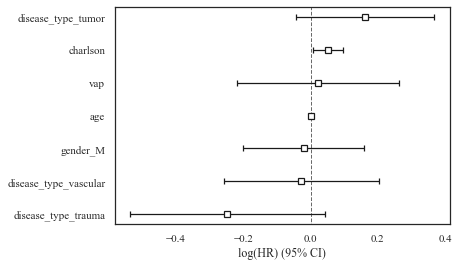

In [51]:
# Fit time varying Cox model
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(base_df, id_col="id", event_col="event", start_col="start", stop_col="stop", show_progress=True)
ctv.print_summary()
ctv.plot()

In [52]:
###### NVA-HARTI

# Create base df with death
base_df = vae_data_main[['ID', 'day_in_icu_max', 'outcome_death',
                         'age', 'gender_M', 'disease_type_trauma', 'disease_type_tumor',
                          'disease_type_vascular', 'charlson', 'group'
                        ]].groupby('ID').max()
base_df = base_df.loc[base_df.group.isin(['No HAI', 'NVA-HARTI', 'VA+NVA HARTI']), :]
base_df = base_df.drop(['group'], axis=1)
base_df = base_df.reset_index()
base_df.columns = ['id', 'duration', 'event', 'age', 'gender_M', 'disease_type_trauma', 'disease_type_tumor',
                          'disease_type_vascular', 'charlson']
base_df = to_long_format(base_df, duration_col="duration")

# Create HARTI df
event_df = vae_data_main[['ID', 'day_in_icu_bid', 'group']].groupby('ID').max()
event_df = event_df.loc[event_df.group.isin(['NVA-HARTI', 'VA+NVA HARTI']), :]
event_df = event_df.drop(['group'], axis=1)
event_df = event_df.reset_index()
event_df.columns = ['id', 'nva-harti']

# Add covariates
cv = covariates_from_event_matrix(event_df, id_col="id")

# Combine base and harti dfs
base_df = add_covariate_to_timeline(base_df, cv, duration_col="duration", id_col="id", event_col="event")
base_df = base_df.fillna(0)
base_df

/usr/local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:983: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


,age,charlson,disease_type_trauma,disease_type_tumor,disease_type_vascular,event,gender_M,id,nva-harti,start,stop
0,35.0,2.0,0.0,1.0,0.0,0,1.0,1002/16,0.0,0.0,2.0
1,58.0,4.0,0.0,1.0,0.0,0,1.0,1004/16,0.0,0.0,14.0
2,56.0,4.0,0.0,1.0,0.0,0,0.0,1007/15,0.0,0.0,7.0
3,60.0,2.0,0.0,1.0,0.0,0,1.0,1008/16,0.0,0.0,8.0
4,31.0,3.0,0.0,1.0,0.0,1,0.0,1016/11,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
1811,52.0,4.0,0.0,1.0,0.0,0,1.0,99/14,0.0,0.0,3.0
1812,28.0,0.0,1.0,0.0,0.0,0,0.0,994/14,0.0,0.0,3.0
1813,28.0,0.0,1.0,0.0,0.0,0,0.0,994/14,1.0,3.0,12.0
1814,61.0,8.0,0.0,1.0,0.0,1,1.0,994/16,0.0,0.0,4.0


Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -1084.10356, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 5 iterations.


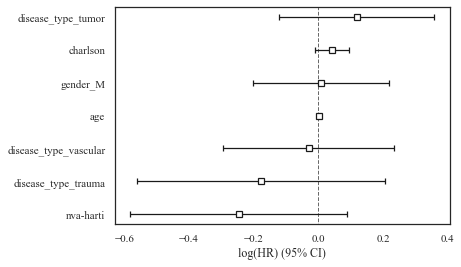

In [53]:
# Fit time varying Cox model
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(base_df, id_col="id", event_col="event", start_col="start", stop_col="stop", show_progress=True)
ctv.print_summary()
ctv.plot()

## Kaplan-Meier model

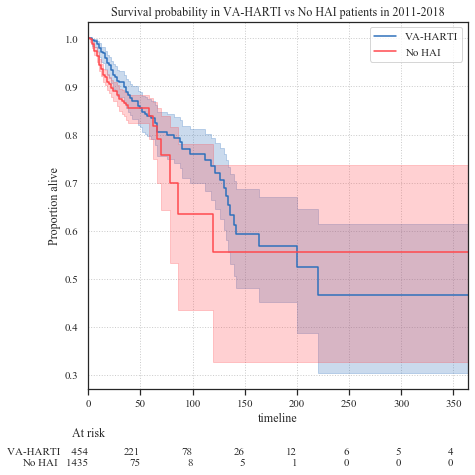

In [54]:
###### Plot Kaplan-Meier for 2 groups (VA-HARTI vs. No HAI)

# Plot VA-HARTI vs. No HAI
T = vae_data_main[['ID', 'los']].groupby('ID').max()
E = vae_data_main[['ID', 'outcome_death']].groupby('ID').max()

# fit the Kaplan-Meier with the subset of data from the class
LIM = 365
colors_sns = ['medium blue', 'light red']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, ax = plt.subplots(1, figsize=(7, 7))

kmf_4 = KaplanMeierFitter()
kmf_4.fit(T.loc[T.index.isin(f4)], E.loc[E.index.isin(f4)], timeline=range(0, LIM, 2), label="VA-HARTI")
kmf_4.plot(ax=ax)

kmf_1 = KaplanMeierFitter()
kmf_1.fit(T.loc[T.index.isin(f1)], E.loc[E.index.isin(f1)], timeline=range(0, LIM, 2), label="No HAI")
kmf_1.plot(ax=ax)

ax.set_title('Survival probability in VA-HARTI vs No HAI patients in 2011-2018')
ax.set_ylabel('Proportion alive')
ax.grid(linestyle='dotted')

add_at_risk_counts(kmf_4, kmf_1, ax=ax)
plt.tight_layout()
plt.savefig('./pictures/survival_km_va-nohai.pdf', dpi=600)

In [55]:
time_limit = 365
rmst_1 = restricted_mean_survival_time(kmf_1, t=time_limit, return_variance=True)
rmst_4 = restricted_mean_survival_time(kmf_4, t=time_limit, return_variance=True)
print('RMST No HAI', rmst_1[0])
print('RMST VA-HARTI', rmst_4[0])
print('STD No HAi: ', np.sqrt(rmst_1[1]))
print('STD VA-HARTI: ', np.sqrt(rmst_4[1]))

/usr/local/lib/python3.7/site-packages/lifelines/utils/__init__.py:333: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 2 * quad(lambda tau: (tau * model.predict(tau)), 0, t)[0]


RMST No HAI 231.3320744568465
RMST VA-HARTI 228.46327283669999
STD No HAi:  151.62841135212904
STD VA-HARTI:  136.6954051492544


## Competing risk model

stats:  False
stats:  False


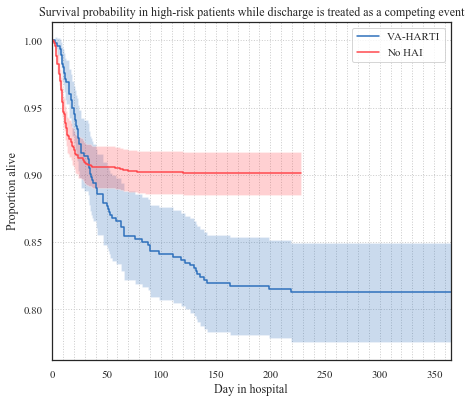

In [56]:
###### Plot competing risk for 2 groups (VA-HARTI vs. No HAI)

# Define data
LIM=365
T = vae_data_main[['ID', 'los']].groupby('ID').max()
E = vae_data_main[['ID', 'outcome_death']].groupby('ID').max()
T_4 = T.loc[T.index.isin(f4)]
T_1 = T.loc[T.index.isin(f1)]
E = E.replace(0, 2)
E_4 = E.loc[E.index.isin(f4)]
E_1 = E.loc[E.index.isin(f1)]

# Plot competing event function
colors_sns = ['medium blue', 'light red']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, ax = plt.subplots(1, 1, figsize=(7,6))
cuminc_res_4 = cuminc(T_4.values.reshape(-1), E_4.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_4.groups.items())[:1]:
    ax.plot(group.time, 1-group.est, label="a")
    ax.fill_between(group.time, 1-group.low_ci, 1-group.high_ci, alpha=0.25)

cuminc_res_1 = cuminc(T_1.values.reshape(-1), E_1.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_1.groups.items())[:1]:
    ax.plot(group.time, 1-group.est, label="f")
    ax.fill_between(group.time, 1-group.low_ci, 1-group.high_ci, alpha=0.25)
   
ax.set_xlim(0, LIM, 1)
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='x')
ax.grid(linestyle='dotted')
ax.legend(['VA-HARTI', 'No HAI'])
ax.set_ylabel('Proportion alive')
ax.set_xlabel('Day in hospital')
ax.set_title('Survival probability in high-risk patients while discharge is treated as a competing event')
plt.tight_layout()
plt.savefig('./pictures/survival_cmprsk_va-nohai.pdf', dpi=600)

stats:  False
stats:  False
stats:  False
stats:  False
stats:  False


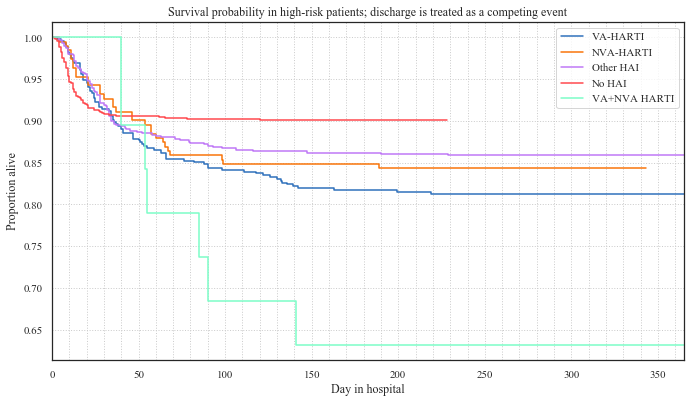

In [57]:
###### Plot competing risk for all groups

# Define data
LIM=365
T = vae_data_main[['ID', 'los']].groupby('ID').max()
E = vae_data_main[['ID', 'outcome_death']].groupby('ID').max()
T_1 = T.loc[T.index.isin(f1)]
T_2 = T.loc[T.index.isin(f2)]
T_3 = T.loc[T.index.isin(f3)]
T_4 = T.loc[T.index.isin(f4)]
T_5 = T.loc[T.index.isin(f5)]
E = E.replace(0, 2)
E_1 = E.loc[E.index.isin(f1)]
E_2 = E.loc[E.index.isin(f2)]
E_3 = E.loc[E.index.isin(f3)]
E_4 = E.loc[E.index.isin(f4)]
E_5 = E.loc[E.index.isin(f5)]

# Plot competing event function
colors_sns = ['medium blue', 'orange', 'light purple', 'light red', 'light aquamarine']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, ax = plt.subplots(1, 1, figsize=(10,6))

cuminc_res_4 = cuminc(T_4.values.reshape(-1), E_4.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_4.groups.items())[:1]:
    ax.plot(group.time, 1-group.est)

cuminc_res_3 = cuminc(T_3.values.reshape(-1), E_3.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_3.groups.items())[:1]:
    ax.plot(group.time, 1-group.est)

cuminc_res_2 = cuminc(T_2.values.reshape(-1), E_2.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_2.groups.items())[:1]:
    ax.plot(group.time, 1-group.est)

cuminc_res_1 = cuminc(T_1.values.reshape(-1), E_1.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_1.groups.items())[:1]:
    ax.plot(group.time, 1-group.est)

cuminc_res_5 = cuminc(T_5.values.reshape(-1), E_5.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_5.groups.items())[:1]:
    ax.plot(group.time, 1-group.est)

ax.set_xlim(0, LIM, 1)
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='x')
ax.grid(linestyle='dotted')
ax.legend(['VA-HARTI', 'NVA-HARTI', 'Other HAI', 'No HAI', 'VA+NVA HARTI'])
ax.set_ylabel('Proportion alive')
ax.set_xlabel('Day in hospital')
ax.set_title('Survival probability in high-risk patients; discharge is treated as a competing event')
plt.tight_layout()
plt.savefig('./pictures/survival_cmprsk_all.pdf', dpi=600)

# Alter data for Kaplan-Meier to get the same result as in competing risk model

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


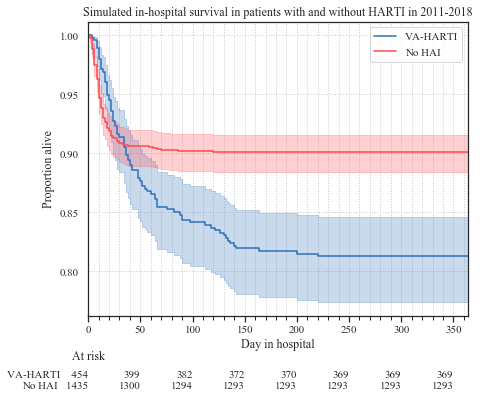

In [58]:
# Define uncensored data
LIM = 365
T = vae_data_main[['ID', 'los', 'outcome_death']].groupby('ID').max()
T['los'][T.outcome_death ==0 ] = LIM
E = pd.DataFrame(T.outcome_death)
T = pd.DataFrame(T.los)

# fit the Kaplan-Meier
colors_sns = ['medium blue', 'light red']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, ax = plt.subplots(1, figsize=(7, 6))
kmf_4 = KaplanMeierFitter()
kmf_4.fit(T.loc[T.index.isin(f4)], E.loc[E.index.isin(f4)], timeline=range(0, LIM, 2), label="VA-HARTI")
kmf_4.plot(ax=ax)

kmf_1 = KaplanMeierFitter()
kmf_1.fit(T.loc[T.index.isin(f1)], E.loc[E.index.isin(f1)], timeline=range(0, LIM, 2), label="No HAI")
kmf_1.plot(ax=ax)

ax.set_title('Simulated in-hospital survival in patients with and without HARTI in 2011-2018')
ax.set_ylabel('Proportion alive')
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='x')
ax.grid(linestyle='dotted')
ax.set_xlabel('Day in hospital')
add_at_risk_counts(kmf_4, kmf_1, ax=ax)
plt.savefig('./pictures/survival_km_vap-nohai_simulated.pdf', dpi=600)

In [59]:
# Calulate survival difference at fixed point in time
tpoint = 52
results = survival_difference_at_fixed_point_in_time_test(tpoint, T.loc[T.index.isin(f1)],
                                                          T.loc[T.index.isin(f4)],
                                                          event_observed_A=E.loc[E.index.isin(f1)],
                                                          event_observed_B=E.loc[E.index.isin(f4)])
results.print_summary()

# Compare mortality in HARTI vs No HARTI by competing risk

stats:  False
stats:  False


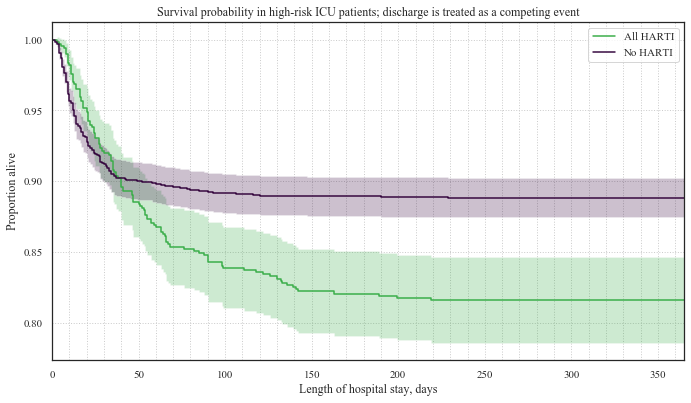

In [60]:
# define data
T = vae_data_main[['ID', 'los']].groupby('ID').max()
E = vae_data_main[['ID', 'outcome_death']].groupby('ID').max()
f6 = df_individuals[(df_individuals.group.isin([3,4,5]))].index.tolist() # All HARTI
f7 = df_individuals[(df_individuals.group.isin([1,2]))].index.tolist() # No HARTI

T_6 = T.loc[T.index.isin(f6)]
T_7 = T.loc[T.index.isin(f7)]
E = E.replace(0, 2)
E_6 = E.loc[E.index.isin(f6)]
E_7 = E.loc[E.index.isin(f7)]

# Plot competing event function
LIM=365
colors_sns = [ 'medium green', 'dark purple']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, ax = plt.subplots(1, 1, figsize=(10,6))

cuminc_res_6 = cuminc(T_6.values.reshape(-1), E_6.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_6.groups.items())[:1]:
    ax.plot(group.time, 1-group.est, label="All HARTI")
    ax.fill_between(group.time, 1-group.low_ci, 1-group.high_ci, alpha=0.25)
    ax.set_xlim(0, LIM, 1)
    
cuminc_res_7 = cuminc(T_7.values.reshape(-1), E_7.values.reshape(-1).astype('float64'))
for name, group in list(cuminc_res_7.groups.items())[:1]:
    ax.plot(group.time, 1-group.est, label="No HARTI")
    ax.fill_between(group.time, 1-group.low_ci, 1-group.high_ci, alpha=0.25)
    ax.set_xlim(0, LIM, 1)

ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='x')
ax.grid(linestyle='dotted')
ax.legend(['All HARTI', 'No HARTI'])
ax.set_ylabel('Proportion alive')
ax.set_xlabel('Length of hospital stay, days')
ax.set_title('Survival probability in high-risk ICU patients; discharge is treated as a competing event')
plt.tight_layout()
plt.savefig('./pictures/survival_cmprsk_harti-noharti.pdf', dpi=600)

# Logistic regression for mortality
### VA-HARTI

In [61]:
##### Select all related factors by data type
# Numerical factors
FACTORS = ['age', 'charlson',  # condition on admission
           'st_device_len_sum', 'st_other_len_sum', 'st_craniotomy_len_sum', 'st_endovascular_len_sum',
           'st_endonasal_len_sum', 'st_spinal_len_sum','st_device_count', 'st_other_count',
           'st_craniotomy_count', 'st_endovascular_count',
           'st_endonasal_count', 'st_spinal_count', 'st_all_sum',
           
           'consciousness', 'rass',  # severity of patients condition 
           'pbss', 'aphasia',
           
           'days_mech_vent_before_tracheostomy', 'days_before_tracheostomy', # ICU care
           'mech_vent_d', 'central_line_d', 'feeding_tube_d',
             'arterial_line_d', 'antibiotics_total_binary_d', 'evd_d', 'icpm_d',
             'urinary_catheter_d', 'csfl_ne_d', 'csfl_ss_d', 'hypothermia_d', 'hemodialysis_d',
             'total_parenteral_feeding_d', 'sedation_d', 'anxiolytics_d', 'vasopressors_d',
             'endotracheal_tube_0.0_d', 'endotracheal_tube_1.0_d', 'endotracheal_tube_2.0_d',
             'endotracheal_tube_3.0_d',
           
            'intestinal_dysfunction_d',   # complications
             'infection_cns_d', 'infection_bloodstream_d',
             'infection_urinary_d', 'infection_ssi_d', 'infection_other_d',
           ]

# Proportional factors
FACTORS_2 = ['gender_M', 'disease_type_trauma', 'disease_type_tumor', # condition on admission
             'disease_type_vascular', 'disease_type_other',
             
             'mutism', 'convulsions', 'convulsions_d',   # severity of patients condition 
             'aphasia_d', 'mutism_d',
             
             'mech_vent',   'antibiotics_total_binary', 
             'central_line', 'feeding_tube', 'arterial_line', 'evd', 'icpm',
             'urinary_catheter', 'hypothermia', 'hemodialysis', 'total_parenteral_feeding',
             'sedation', 'anxiolytics', 'vasopressors', 'endotracheal_tube_0.0', 'endotracheal_tube_1.0',
             'endotracheal_tube_2.0', 'endotracheal_tube_3.0',
             'antibiotics_total_binary', 
           
             'intestinal_dysfunction', 'infection_bloodstream', 'infection_other',  # complications
             'csfl_ne', 'csfl_ss', 'infection_urinary', 'infection_cns'
            ]


In [62]:
######## Univariate analysis for VA-HARTI

# Define data
data_vap = vae_data_main[(vae_data_main.group == 'VA-HARTI')]
data_novap = vae_data_main[(vae_data_main.group != 'VA-HARTI')]

# Calculate p-values for continuous and binary variables
pvals = {}
for factor in FACTORS:
    pvals[factor] = stats.ttest_ind(data_vap[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                        data_novap[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                          equal_var = False).pvalue
pvalues = pd.DataFrame({'pvalue': pvals})
    
pvals = {}
for factor in FACTORS_2:
    vals = [data_vap[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values,
            data_novap[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values]
    pvals[factor] = chi(vals)[1]
pvalues = pd.concat([pvalues, pd.DataFrame({'pvalue': pvals})], axis=0)

# Adjust p-values for multiple comparison
pvalues['adjusted_pvalue'] = pd.Series(multipletests(pvalues.pvalue.dropna().values)[1],
                                       index=pvalues.pvalue.dropna().index)
pvalues['adjusted_pvalue'] = pvalues['adjusted_pvalue'].apply(lambda x: round(x, 5))


In [63]:
###### First step - test predictors for VA-HARTI

# Include columns that showed significancr in univariate analysis
COLS = pvalues[(pvalues.adjusted_pvalue >= 0.05)].index
COLS = COLS.tolist() + ['ID_subid']

# Define data
logreg_data = vae_data_main[COLS].groupby('ID_subid').max()
y = vae_data_main[['ID_subid', 'vap']].groupby('ID_subid').max().astype(float)
X = sm.add_constant(logreg_data.astype(float))

# Test predictors for VA-HARTI
logit_model = sm.Logit(y, X)
result = logit_model.fit_regularized()

# Select variables that are not independent risk factors for VA-HARTI
predictors = result.summary2().tables[1]['P>|z|']
predictors = predictors[predictors >= 0.05].index
# Predictors to be used
predictors_vap = predictors.tolist() + ['vap'] + ['ID_subid']
predictors_vap

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.39998997591252694
            Iterations: 132
            Function evaluations: 152
            Gradient evaluations: 132


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


['endotracheal_tube_2.0_d',
 'st_craniotomy_count',
 'st_craniotomy_len_sum',
 'st_endovascular_count',
 'st_endovascular_len_sum',
 'st_spinal_count',
 'st_spinal_len_sum',
 'convulsions',
 'disease_type_vascular',
 'endotracheal_tube_2.0',
 'evd',
 'vap',
 'ID_subid']

In [64]:
###### Second step - use selected variables to fit logreg to select independent risk factors for mortality

# Remove correlated factors (binary variable in a pair)
predictors_vap.remove('endotracheal_tube_2.0')

# Define x and y
predictors_vap.remove('const') if 'const' in predictors_vap else predictors_vap
logreg_data = vae_data_main[predictors_vap].groupby('ID_subid').max()
y = vae_data_main[['ID_subid', 'outcome_death']].groupby('ID_subid').max()
X = sm.add_constant(logreg_data)

# fit model
logit_model=sm.Logit(y.astype(float), X.astype(float))
result=logit_model.fit_regularized()
print(result.summary2())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.38497139419248355
            Iterations: 70
            Function evaluations: 83
            Gradient evaluations: 70
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.029     
Dependent Variable:    outcome_death      AIC:                2300.7208 
Date:                  2020-08-21 12:53   BIC:                2372.6240 
No. Observations:      2957               Log-Likelihood:     -1138.4   
Df Model:              11                 LL-Null:            -1171.8   
Df Residuals:          2945               LLR p-value:        4.6765e-10
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        70.0000                                          
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------

In [65]:
odds_vap = result.summary2().tables[1][['Coef.', '[0.025', '0.975]', 'P>|z|']].apply(
    {'Coef.': np.exp,
     '[0.025': np.exp,
     '0.975]': np.exp,
     'P>|z|': lambda x: f'{x:.04f}'})
odds_vap.columns = ('Odds ratio', 'Lower', 'Upper', 'p_value')
odds_vap

#odds_vap.loc[(odds_vap.p_value.astype(float) <= 0.05)]

,Odds ratio,Lower,Upper,p_value
const,0.119965,0.097429,0.147713,0.0000
endotracheal_tube_2.0_d,0.852712,0.536907,1.354270,0.4996
st_craniotomy_count,1.299901,1.049661,1.609799,0.0162
st_craniotomy_len_sum,0.998793,0.997960,0.999626,0.0045
st_endovascular_count,1.126415,0.789793,1.606511,0.5111
st_endovascular_len_sum,0.999316,0.995834,1.002810,0.7006
st_spinal_count,1.311699,0.650224,2.646094,0.4486
st_spinal_len_sum,1.000522,0.998772,1.002274,0.5591
convulsions,1.290694,0.885424,1.881462,0.1845
disease_type_vascular,0.736813,0.547955,0.990763,0.0432


### Test the performance of the mortality logreg model; VA-HARTI

In [66]:
# Split into train and test subsets
scaler = StandardScaler()
scaler.fit(logreg_data)

x_train, x_test, y_train, y_test = \
    train_test_split(logreg_data, 
                     y, test_size=0.2, random_state=0)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Fit logreg model
model = LogisticRegression(solver='lbfgs', C=10, random_state=0, class_weight='balanced')
model.fit(x_train, y_train.values.reshape(-1))

print("Accuracy on train set; mortality model: ", model.score(x_train, y_train))
print("Accuracy of test set; mortality model: ", model.score(x_test, y_test))
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)
print("F1 score; VAP~mortality model: ", f1_score(y_test, y_pred))
print('ROC-AUC score, VAP~mortality model: ', roc_auc_score(y_test, y_pred))

Accuracy on train set; mortality model:  0.6215644820295984
Accuracy of test set; mortality model:  0.5844594594594594
F1 score; VAP~mortality model:  0.25903614457831325
ROC-AUC score, VAP~mortality model:  0.5619095938730643


In [67]:
# Show full report
print(classification_report(y_test, y_pred))

# Print coefficients
thetas = {v: k for k,v in zip(model.coef_.reshape(-1), logreg_data.columns.values.reshape(-1))}
thetas

              precision    recall  f1-score   support

           0       0.89      0.59      0.71       511
           1       0.17      0.53      0.26        81

    accuracy                           0.58       592
   macro avg       0.53      0.56      0.49       592
weighted avg       0.79      0.58      0.65       592



{'endotracheal_tube_2.0_d': -0.062327026494157466,
 'st_craniotomy_count': 0.2342431935790332,
 'st_craniotomy_len_sum': -0.26962555864475934,
 'st_endovascular_count': 0.07994094434999956,
 'st_endovascular_len_sum': -5.001030407754737e-05,
 'st_spinal_count': 0.029224914149886167,
 'st_spinal_len_sum': 0.04393009618375953,
 'convulsions': 0.0420127643657828,
 'disease_type_vascular': -0.19780526138046753,
 'evd': 0.2913741403384491,
 'vap': 0.1791570210539316}

### NVA-HARTI

In [68]:
######## Univariate analysis for VA-HARTI
# Define data
data_nva = vae_data_main[(vae_data_main.group == 'NVA-HARTI')]
data_nonva = vae_data_main[(vae_data_main.group != 'NVA-HARTI')]

# Calculate p-values for continuous and binary variables
pvals = {}
for factor in FACTORS:
    pvals[factor] = stats.ttest_ind(data_nva[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                        data_nonva[['ID_subid', factor]].groupby('ID_subid').max()[factor].values,
                          equal_var = False).pvalue
pvalues = pd.DataFrame({'pvalue': pvals})
    
pvals = {}
for factor in FACTORS_2:
    vals = [data_nva[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values,
            data_nonva[['ID_subid', factor]].groupby('ID_subid').max()[factor].agg(['count', 'sum']).values]
    pvals[factor] = chi(vals)[1]
pvalues = pd.concat([pvalues, pd.DataFrame({'pvalue': pvals})], axis=0)

# Adjust p-values for multiple comparison
pvalues['adjusted_pvalue'] = pd.Series(multipletests(pvalues.pvalue.dropna().values)[1],
                                       index=pvalues.pvalue.dropna().index)
pvalues['adjusted_pvalue'] = pvalues['adjusted_pvalue'].apply(lambda x: round(x, 5))

In [69]:
#### First step

# Include columns that showed significancr in univariate analysis
COLS = pvalues[(pvalues.adjusted_pvalue >= 0.05)].index
COLS = COLS.tolist() + ['ID_subid']

# Define data
logreg_data = vae_data_main[COLS].groupby('ID_subid').max()
y = vae_data_main[['ID_subid', 'non_vap_resp_hai']].groupby('ID_subid').max().astype(float)
X = sm.add_constant(logreg_data.astype(float))

# Test predictors for NVA-HARTI
logit_model = sm.Logit(y, X)
result = logit_model.fit_regularized()
predictors = result.summary2().tables[1]['P>|z|']
predictors = predictors[predictors >= 0.05].index
# Predictors to be used
predictors_nva = predictors.tolist() + ['non_vap_resp_hai'] + ['ID_subid']
predictors_nva

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.21119508720898128
            Iterations: 341
            Function evaluations: 373
            Gradient evaluations: 341


['age',
 'aphasia',
 'arterial_line_d',
 'charlson',
 'consciousness',
 'csfl_ne_d',
 'csfl_ss_d',
 'endotracheal_tube_1.0_d',
 'endotracheal_tube_2.0_d',
 'hemodialysis_d',
 'hypothermia_d',
 'icpm_d',
 'infection_bloodstream_d',
 'infection_cns_d',
 'infection_other_d',
 'infection_ssi_d',
 'infection_urinary_d',
 'intestinal_dysfunction_d',
 'mech_vent_d',
 'st_craniotomy_count',
 'st_craniotomy_len_sum',
 'st_device_len_sum',
 'st_endonasal_count',
 'st_endonasal_len_sum',
 'st_endovascular_len_sum',
 'st_other_len_sum',
 'st_spinal_count',
 'st_spinal_len_sum',
 'total_parenteral_feeding_d',
 'vasopressors_d',
 'anxiolytics',
 'arterial_line',
 'central_line',
 'convulsions',
 'convulsions_d',
 'csfl_ne',
 'csfl_ss',
 'disease_type_other',
 'disease_type_vascular',
 'endotracheal_tube_0.0',
 'endotracheal_tube_1.0',
 'endotracheal_tube_2.0',
 'evd',
 'feeding_tube',
 'hemodialysis',
 'hypothermia',
 'icpm',
 'infection_cns',
 'infection_other',
 'infection_urinary',
 'mutism',
 'm

In [70]:
#### Second step

# Remove correlated factors (binary variable in a pair)
predictors_nva.remove('arterial_line')
predictors_nva.remove('csfl_ne')
predictors_nva.remove('csfl_ss')
predictors_nva.remove('endotracheal_tube_1.0')
predictors_nva.remove('endotracheal_tube_2.0')
predictors_nva.remove('hemodialysis')
predictors_nva.remove('hypothermia')
predictors_nva.remove('icpm')
predictors_nva.remove('infection_cns')
predictors_nva.remove('infection_other')
predictors_nva.remove('infection_urinary')
predictors_nva.remove('convulsions')
predictors_nva.remove('total_parenteral_feeding')
predictors_nva.remove('mutism')
predictors_nva.remove('vasopressors')

# Define x and y
predictors_nva.remove('const') if 'const' in predictors_nva else predictors_nva
logreg_data = vae_data_main[predictors_nva].groupby('ID_subid').max()
y = vae_data_main[['ID_subid', 'outcome_death']].groupby('ID_subid').max()
X = sm.add_constant(logreg_data)

# Fit model
logit_model = sm.Logit(y.astype(float), X.astype(float))
result = logit_model.fit_regularized()
print(result.summary2())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2847909535290103
            Iterations: 129
            Function evaluations: 158
            Gradient evaluations: 129
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.281      
Dependent Variable:    outcome_death       AIC:                 1768.2537  
Date:                  2020-08-21 12:54    BIC:                 2019.9148  
No. Observations:      2957                Log-Likelihood:      -842.13    
Df Model:              41                  LL-Null:             -1171.8    
Df Residuals:          2915                LLR p-value:         1.6287e-112
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        129.0000                                            
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z

In [71]:
odds_nva = result.summary2().tables[1][['Coef.', '[0.025', '0.975]', 'P>|z|']].apply(
    {'Coef.': np.exp,
     '[0.025': np.exp,
     '0.975]': np.exp,
     'P>|z|': lambda x: f'{x:.04f}'})
odds_nva.columns = ('Odds ratio', 'Lower', 'Upper', 'p_value')
odds_nva
#odds_nva.loc[(odds_nva.p_value.astype(float) <= 0.05)]

,Odds ratio,Lower,Upper,p_value
const,0.571239,0.205171,1.590445,0.2838
age,1.002945,0.993982,1.011988,0.5209
aphasia,0.656598,0.381710,1.129445,0.1285
arterial_line_d,0.979965,0.944339,1.016935,0.2841
charlson,1.314858,1.214156,1.423912,0.0000
consciousness,0.503775,0.457563,0.554655,0.0000
csfl_ne_d,1.011789,0.954417,1.072611,0.6939
csfl_ss_d,0.980912,0.904922,1.063282,0.6395
endotracheal_tube_1.0_d,1.008963,0.983720,1.034854,0.4900
endotracheal_tube_2.0_d,0.988676,0.666685,1.466180,0.9548


### Test the performance of the mortality logreg model; NVA-HARTI

In [72]:
# Split into train and test subsets
scaler = StandardScaler()
scaler.fit(logreg_data)

x_train, x_test, y_train, y_test = \
    train_test_split(logreg_data, 
                     y, test_size=0.2, random_state=0)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Fit logreg model
model = LogisticRegression(solver='lbfgs', C=10, random_state=0, class_weight='balanced')
model.fit(x_train, y_train.values.reshape(-1))

print("Accuracy on train set; mortality model: ", model.score(x_train, y_train))
print("Accuracy of test set; mortality model: ", model.score(x_test, y_test))
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)
print("F1 score; NVA~mortality model: ", f1_score(y_test, y_pred))
print('ROC-AUC score, NVA~mortality model: ', roc_auc_score(y_test, y_pred))

Accuracy on train set; mortality model:  0.7873150105708245
Accuracy of test set; mortality model:  0.7820945945945946
F1 score; NVA~mortality model:  0.4860557768924303
ROC-AUC score, NVA~mortality model:  0.7698895895242928


In [73]:
# Show full report
print(classification_report(y_test, y_pred))

# Print coefficients
thetas = {v: k for k,v in zip(model.coef_.reshape(-1), logreg_data.columns.values.reshape(-1))}
thetas

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       511
           1       0.36      0.75      0.49        81

    accuracy                           0.78       592
   macro avg       0.66      0.77      0.67       592
weighted avg       0.87      0.78      0.81       592



{'age': 0.0967931056298792,
 'aphasia': -0.12262356856369404,
 'arterial_line_d': -0.1278876994434109,
 'charlson': 0.6515093521053555,
 'consciousness': -0.7941945342074141,
 'csfl_ne_d': -0.015674905315151425,
 'csfl_ss_d': 0.009498104504122255,
 'endotracheal_tube_1.0_d': 0.013855006997422715,
 'endotracheal_tube_2.0_d': 0.01050307146925509,
 'hemodialysis_d': 0.23511560687828406,
 'hypothermia_d': 0.09248009568206261,
 'icpm_d': -0.13725052628421408,
 'infection_bloodstream_d': -0.004346708474063724,
 'infection_cns_d': 0.1630801067453143,
 'infection_other_d': 0.1561678308374517,
 'infection_ssi_d': 0.07493196477491125,
 'infection_urinary_d': -0.1742938949068897,
 'intestinal_dysfunction_d': 0.06982903423466698,
 'mech_vent_d': -0.2544436142072927,
 'st_craniotomy_count': 0.16467788111742246,
 'st_craniotomy_len_sum': -0.19700239320155408,
 'st_device_len_sum': -0.017443500961555232,
 'st_endonasal_count': 0.1340853241700878,
 'st_endonasal_len_sum': -0.3028323506317635,
 'st_end

________